# Diagnosing relationship of breaths to ventilator

Import libraries

In [1]:
#%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
from numpy import diff
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as interp
import textdistance
# IMPORT Ole's fixed TMSiSDK python interfacwe- may change
sys.path.insert(0,'C:/Projects/tmsi-python-interface')
from TMSiSDK.file_readers import Poly5Reader
import collections
import math
sys.path.insert(0, '../resurfemg')
import helper_functions as hf

C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [2]:
# do not rerun this cell
big_data_list= []

In [3]:
stacked_emg_directory = '../researcher_interface/output_emg_processed'
os.listdir(stacked_emg_directory )

['not_pushedtopspin_data_anonymizedM002005EMG_recording']

In [4]:
file_name = os.path.join(stacked_emg_directory,'not_pushedtopspin_data_anonymizedM002005EMG_recording')

In [5]:
file = np.load(file_name)

In [6]:
file

array([[ 7.03945975e-05, -4.59417200e-03, -5.48236952e-03, ...,
        -1.03932648e-03, -9.48208055e-04, -1.08099285e-05],
       [ 5.02129984e+00,  5.02129984e+00,  5.07130003e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.97669983e+00, -6.61670017e+00, -6.34660006e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.86008987e+01,  4.72509003e+01,  4.59007988e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e-02,  2.00000000e-02, ...,
         4.64070000e+02,  4.64080000e+02,  4.64090000e+02]])

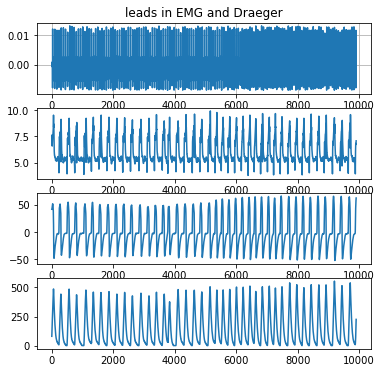

In [7]:
%matplotlib inline
# set up plot, show
x_emg = file
#x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(6, 6))
axis[0,].grid(True)
axis[0,].plot(x_emg[0][100:10000])
axis[0,].set(title='leads in EMG and Draeger')
axis[1,].plot(x_emg[1][100:10000])
axis[2,].plot(x_emg[2][100:10000])
axis[3,].plot(x_emg[3][100:10000])


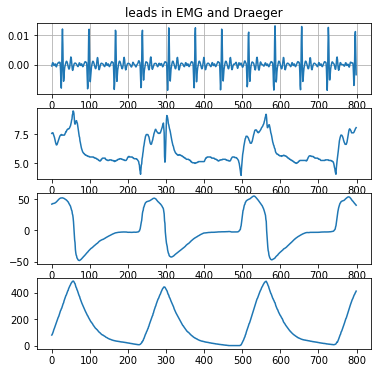

In [8]:
%matplotlib inline
# set up plot, show
x_emg = file
#x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(6, 6))
axis[0,].grid(True)
axis[0,].plot(x_emg[0][100:900])
axis[0,].set(title='leads in EMG and Draeger')
axis[1,].plot(x_emg[1][100:900])
axis[2,].plot(x_emg[2][100:900])
axis[3,].plot(x_emg[3][100:900])

# OK downsampling has made this a nightmare...but let's continue for the sake of algorithm development.

Let's examing how well the ventilator signals line up.

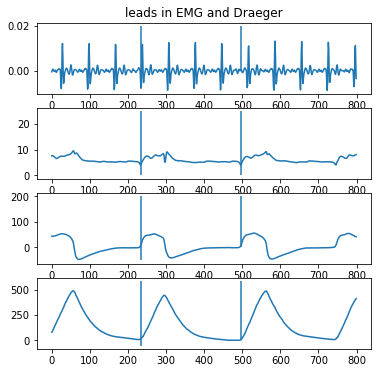

In [9]:
%matplotlib inline
# set up plot, show
x_emg = file
#x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(6, 6),)
min = x_emg.min()
max = x_emg.max()

axis[0,].set(title='leads in EMG and Draeger')
axis[0,].plot(x_emg[0][100:900])
axis[0,].vlines(235, 0, 0.02)
axis[0,].vlines(497, 0, 0.02)
axis[1,].plot(x_emg[1][100:900])
axis[1,].vlines(235, 0, 25)
axis[1,].vlines(497, 0, 25)
axis[2,].plot(x_emg[2][100:900])
axis[2,].vlines(235, min, 200)
axis[2,].vlines(497, 0, 200)
axis[3,].plot(x_emg[3][100:900])
axis[3,].vlines(235, min, max)
axis[3,].vlines(497, 0, max)

# OK, b ecause of the way our signal was processed, we will imagine we want to match ECG peaks to the vent signal...this is all to build an algorithm

We first need to break down the ventilator signal

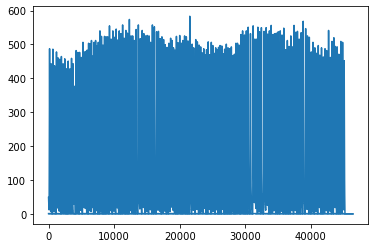

In [10]:
low_per = 0.05
plt.plot(hf.zero_one_for_jumps_base(
            x_emg[3], x_emg[3].max()*low_per), color='C0')
plt.plot(x_emg[3])

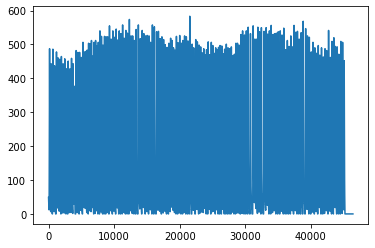

In [11]:
plt.plot(x_emg[3])

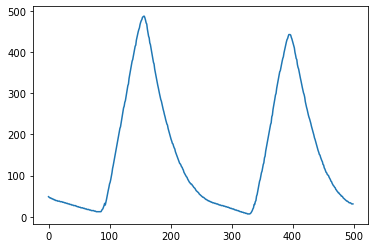

In [12]:
plt.plot(x_emg[3][0:500])

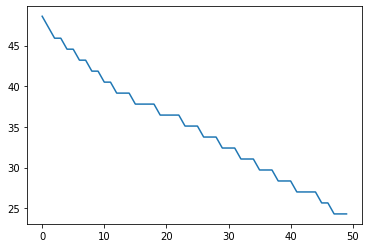

In [13]:
plt.plot(x_emg[3][0:50])

On the third lead we can tag the turns to give us insight into the ventilator activity. We can use the derivate. But we must first smooth the curve

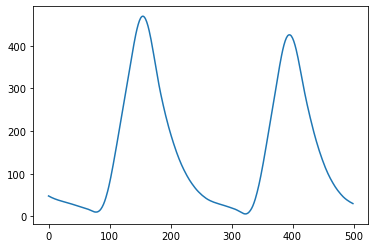

In [14]:
yhat = scipy.signal.savgol_filter(x_emg[3], 51, 3)
plt.plot(yhat[0:500])

In [15]:
from numpy import diff
dx = 1
y = yhat
dy = diff(y)/dx
print (dy)
#array([ 10.,  10.,  10.,   0.,  10.,  10.])

[-0.78605396 -0.75807204 -0.7311018  ...  0.          0.
  0.        ]


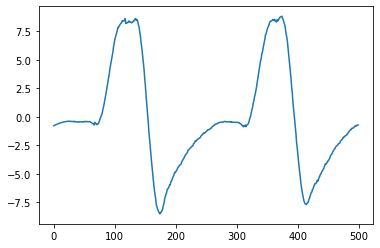

In [16]:
plt.plot(dy[0:500])

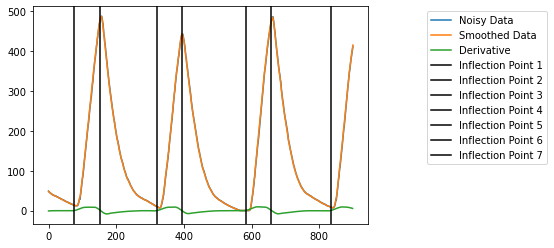

In [17]:
raw = (x_emg[3][0:900])
# smooth
smooth_data =  scipy.signal.savgol_filter(x_emg[3], 10, 3)
smooth_data = smooth_data[0:900]

# compute derivative

smooth_d2 = diff(smooth_data)/dx
smooth_d2 = scipy.signal.savgol_filter(smooth_d2, 50, 3)

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.plot(raw, label='Noisy Data')
plt.plot(smooth_data, label='Smoothed Data')
plt.plot(smooth_d2 , label='Derivative ')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

# now let's tag ventilator pushes-
we could say we have different kinds of inflections.
one headed up, and one headed down.

One approach would be to tag start and stop seperately

In [18]:
inflections_up= []
inflections_down = []
for point in infls:
    if smooth_data[(point+30)] > smooth_data[point]:
        inflections_up.append(point)
    else:
        inflections_down.append(point)
    
print("ups", inflections_up)
print("downs", inflections_down)

ups [76, 321, 582, 833]
downs [153, 393, 658]


We can also probably just use where derviate is greater than zero.

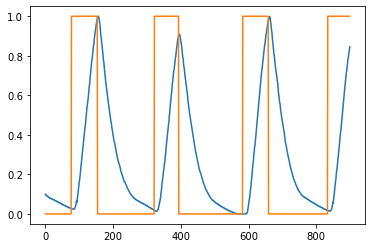

In [19]:
plt.plot(raw/raw.max())# scaled raw data in blue
#plt.plot(smooth_d2 )
cut_off = 0
zero_one_derviv = hf.zero_one_for_jumps_base(smooth_d2, cut_off)
plt.plot(zero_one_derviv)

Note that due to smoothing we pushed the start of ventilation back in time. Good enough for now. Now let's create a lagging and leading situation

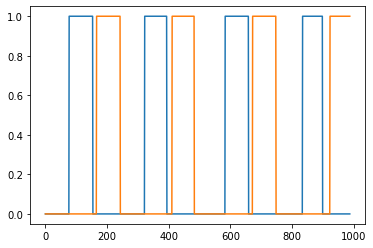

In [20]:
signal1_machine= np.append(zero_one_derviv,np.zeros(89))
signal2_psuedohuman = np.append(np.zeros(89), zero_one_derviv)
#signal2_psuedohuman = np.append(np.zeros(99), zero_one_derviv)
plt.plot(signal1_machine)
plt.plot(signal2_psuedohuman)

In [21]:
# can we diagnose the percentage overlap?
# Can we diagnose the human as before or breating after the machine?

# we assume a synchrony point on zero

In [22]:
print(type(signal2_psuedohuman))

<class 'numpy.ndarray'>


In [23]:
raw_overlap_percent = sum(signal1_machine.astype(int) & signal2_psuedohuman.astype(int))/len(signal1_machine.astype(int))
raw_overlap_percent

0.0

In [24]:
def raw_overlap_percent(signal1, signal2):
    if len(signal1) != len(signal2):
        print('Warning: legnth of arrays is not matched')
    raw_overlap_percent = sum(signal1.astype(int) & signal2.astype(int))/len(signal1.astype(int))
    return raw_overlap_percent

In [29]:
signal1 = [0,0,0,0]
signal2= [1,0,1]
longer_signal_len = np.max([len(signal1), len(signal2)])
longer_signal_len

4

In [25]:
raw_overlap_percent(signal1_machine, signal2_psuedohuman)

0.0

Can we use 'edit distance' to descibe similarity?, what does edit distacnce tell us?
Let's examine an example for later discussion with scientists

In [51]:

# S1=[1,2,3,7,9,15,19,20,100,100,100]
# S2=[100,100,1,1,2,3,7,8,14,20,24]
S1 = [0,0,0,0,1,1,1,0,0,0]
S2 = [0,1,0,0,1,1,1,0,0,1]
S3 = [0,1,0,1,0,1,0,1,0,1]
S4 = [1,1,1,1,1,1,1,1,1,1]
S5 = [0,0,0,0,0,1,1,1,1,0]
S6 = [0,0,0,1,1,1,1,0,0,0]
print(textdistance.levenshtein.similarity(S1,S1))
print(textdistance.levenshtein.similarity(S1,S2))
print(textdistance.levenshtein.similarity(S1,S3))
print(textdistance.levenshtein.similarity(S1,S4))
print(textdistance.levenshtein.similarity(S1,S5))
print(textdistance.levenshtein.similarity(S1,S6))
#textdistance.levenshtein.distance(S1,S2)

10
8
5
3
7
9


So we see in theory the textdifference  levenshtein algorithm could tell us something, even if we have an  'alphabet' greaterthan zeros and ones. This gives us more information than raw overlap. 

We can also compare counts of each activity. 

In [55]:
machine_breaths = hf.count_decision_array(signal1_machine)
human_breaths = hf.count_decision_array(signal2_psuedohuman)
unmatched_efforts = human_breaths - machine_breaths
unmatched_efforts

-0.5

The above could be normalized to total machine or human efforts.

In [90]:
# #machine_breaths_set = []
# human_breaths_set = []
# # for i in np.where(signal1_machine ==1):
# #     machine_breaths_set.append(i)
# where_machine=np.where(signal1_machine ==1)
# x_hashable = map(tuple, where_machine)
# machine_breaths_set= set(x_hashable) 

# human_breaths_set= set(y_hashable)
# #human_breath_set= set(np.where(signal2_psuedohuman ==1))
# machine_breaths_set